In [1]:
%matplotlib inline

In [2]:
import os
import sys
import netCDF4
import numpy as np
from geophys_utils import NetCDFPointUtils, get_spatial_ref_from_wkt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from pprint import pprint
#print(sys.version)
#pprint(dict(os.environ))

In [3]:
def rescale_array(input_np_array, new_range_min=0, new_range_max=1):
    old_min = input_np_array.min()
    old_range = input_np_array.max() - old_min
    new_range = new_range_max - new_range_min

    scaled_np_array = ((input_np_array - old_min) / old_range * new_range) + new_range_min

    return scaled_np_array

In [4]:
def plot_survey_points(netcdf_path, variable_to_map, colour_scheme='binary'):
    try:
        assert os.path.isfile(netcdf_path), 'File {} does not exist!'.format(netcdf_path)
        
        nc = netCDF4.Dataset(netcdf_path)

        netcdf_point_utils = NetCDFPointUtils(nc)

        utm_wkt, utm_coords = netcdf_point_utils.utm_coords(netcdf_point_utils.xycoords[:])

        utm_zone = get_spatial_ref_from_wkt(utm_wkt).GetUTMZone() # -ve for Southern Hemisphere
        southern_hemisphere = (utm_zone < 0)
        utm_zone = abs(utm_zone)
        projection = ccrs.UTM(zone=utm_zone, southern_hemisphere=southern_hemisphere)

        print('utm_zone = {}'.format(utm_zone))
        #print(utm_coords)

        variable = nc.variables[variable_to_map]

        colour_array = rescale_array(variable[:], 0, 1)

        #map_image = cimgt.OSM() # https://www.openstreetmap.org/about
        #map_image = cimgt.StamenTerrain() # http://maps.stamen.com/
        map_image = cimgt.QuadtreeTiles()
        fig = plt.figure(figsize=(30,20))

        ax = fig.add_subplot(1, 1, 1, projection=projection)

        ax.set_title("Point Gravity Survey - " + str(nc.getncattr('title')))

        ax.add_image(map_image, 10)

        # set the x and y axis tick values
        x_min = np.min(utm_coords[:,0])
        x_max = np.max(utm_coords[:,0])
        y_min = np.min(utm_coords[:,1])
        y_max = np.max(utm_coords[:,1])
        
        print('UTM bounding box: {}, {}, {}, {}'.format(x_min, y_min, x_max, y_max))

        range_x = x_max - x_min
        range_y = y_max - y_min

        ax.set_xticks([x_min, range_x / 2 + x_min, x_max])
        ax.set_yticks([y_min, range_y / 2 + y_min, y_max])

        # set the x and y axis labels
        ax.set_xlabel("Eastings (m)", rotation=0, labelpad=20)
        ax.set_ylabel("Northings (m)", rotation=90, labelpad=20)

        # See link for possible colourmap schemes: https://matplotlib.org/examples/color/colormaps_reference.html
        cm = plt.cm.get_cmap(colour_scheme)

        # build a scatter plot of the specified data, define marker, spatial reference system, and the chosen colour map type
        sc = ax.scatter(utm_coords[:,0], 
                        utm_coords[:,1], 
                        marker='o', 
                        c=colour_array, 
                        s=4, 
                        alpha=0.9, 
                        transform=projection, 
                        cmap=cm
                       )

        # set the colour bar ticks and labels
        cb = plt.colorbar(sc, ticks=[0, 1])
        cb.ax.set_yticklabels([str(np.min(variable)), str(np.max(variable))])  # vertically oriented colorbar
        cb.set_label("{} {}".format(variable.long_name, variable.units))

        plt.show()
    except Exception as e:
        print(e) 
    finally:
        del netcdf_point_utils
        del nc

In [5]:
nc_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/ground_gravity/point_datasets/201780.nc'
#nc_path = 'C:\\Temp\\gravity_point_test\\201780.nc'

utm_zone = 53
UTM bounding box: 539789.6868594976, 7983841.687825138, 728564.7401507163, 8304015.832502202


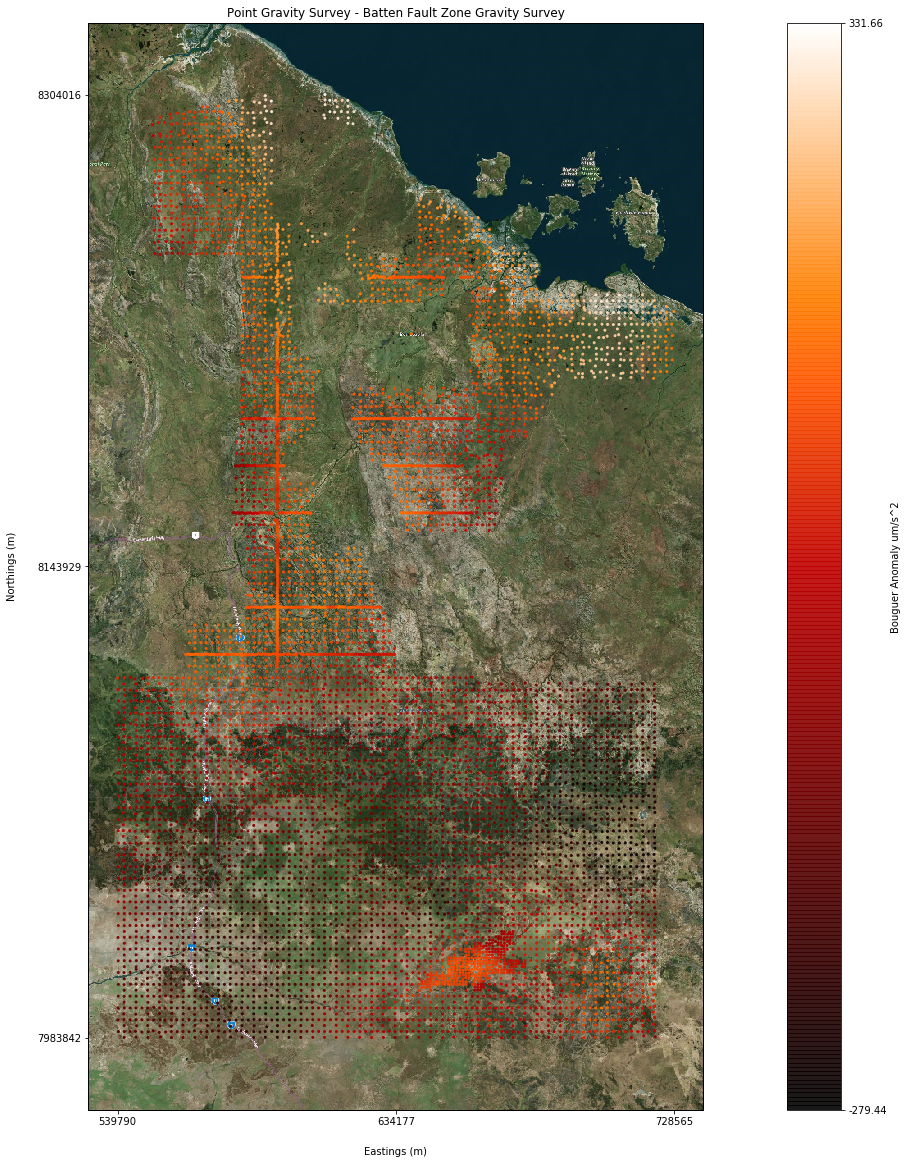

In [6]:
plot_survey_points(nc_path, 'Bouguer', 'gist_heat')